# **Maize Leaf Disease Classification using Vision Transformer (ViT)**

<img src='https://imgs.search.brave.com/06oyAqYkjcVznl17oNdPhEMbiFV4DcV1YGrqbb52NGw/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly9sZWFy/bm9wZW5jdi5jb20v/d3AtY29udGVudC91/cGxvYWRzLzIwMjMv/MDIvaW1hZ2UtOS0x/MDI0eDUzOC5wbmc'>

## **Import Dependencies**

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from tqdm import tqdm
from PIL import Image
import random

import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import random_split, Dataset, DataLoader
import torch.nn.functional as F

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = 'Times New Roman'

import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device, torch.__version__)

# Define the directories
data_dir = 'datasets'

cuda 2.6.0+cu124


## **Define Configs**

In [236]:
IMG_SIZE = 256
BATCH_SIZE = 32
RANDOM_SEED = 42

# Set the seed
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

## **Custom Dataset and DataLoader**

In [113]:
# Custom image dataset class
class CustomDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.image_paths = glob(os.path.join(root_dir, 'data', '*', '*.jpg'))
        self.labels = []
        self.class_to_idx = {}

        for path in self.image_paths:
            label = path.split('\\')[-2]
            self.labels.append(label)

        for i, c in enumerate(set(self.labels)):
            self.class_to_idx[c] = i

        self.labels = [self.class_to_idx[l] for l in self.labels]

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [115]:
# Define the transforms
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [116]:
# Create a custom dataset object
dataset = CustomDataset(data_dir, transform=manual_transforms)

# Split the data into training and testing
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create dataoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=3)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=3)

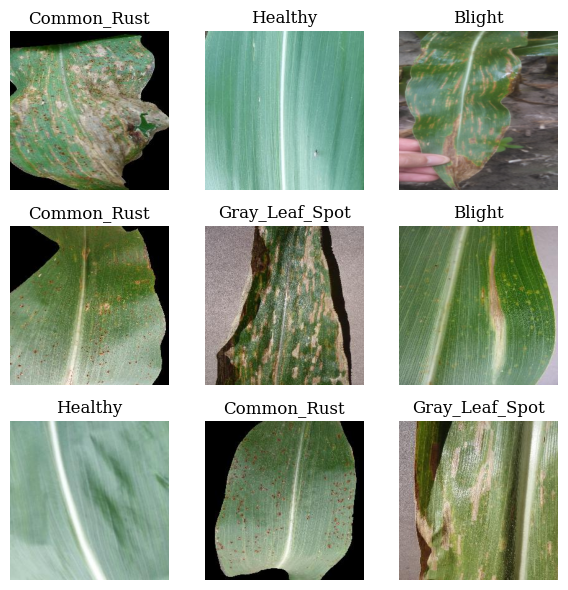

In [176]:
# Plot sample image
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6, 6))
axes = axes.flatten()

for ax in axes:
    random_id = random.randint(0, len(train_dataset))
    img, label = train_dataset.__getitem__(random_id)
    img = img.permute(1, 2, 0).numpy()
    label_name = [k for k, v in dataset.class_to_idx.items() if label == v][0]
    ax.imshow(img)
    ax.set_title(label_name)
    ax.axis('off')

plt.tight_layout()
plt.show()

## **Vision Transformer**

### **`PatchEmbedding` class**

1. **Input:** Accepts an image tensor of shape **(B, C, H, W)** as input.

2. **Patch Extraction:** Uses `Conv2d` to split the image into non-overlapping patches.

3. **Flatten Patches:** Flattens the 2D patch grid into a 1D patch sequence.

4. **Permute Dimensions:** Reorders the output to **(B, N_patches, embedding_dim)** for transformer compatibility.

5. **Assertion Check:** Validates that image dimensions are divisible by the patch size.


In [233]:
class PatchEmbedding(nn.Module):
    """
    Turns a 2D input image into a 1D sequence learnable encoding vector.

    Args:
        in_channels (int): Number of color channels in the input images. Defaults to 3.
        patch_size (int): Size of the patches to divide the image into. Defaults to 16.
        embedding_dim (int): Dimension of the output embedding. Defaults to 768.
    """
    def __init__(self, in_channels=3, patch_size=16, embedding_dim=768):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim

        # Layer to convert image into non-overlapping patches and embed them
        self.patcher = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        # Flatten patch feature maps into sequences
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        # Check if input image resolution is divisible by patch size
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, \
            f"Input image size must be divisible by patch size, got image shape: {(image_resolution, image_resolution)}"

        # Apply patch embedding and flatten
        x = self.patcher(x)
        x = self.flatten(x)

        # Rearrange to (batch_size, num_patches, embedding_dim)
        return x.permute(0, 2, 1)

In [243]:
# Let's test it on a single image
# Create an object of the Patch Embedding
patchify = PatchEmbedding(
    in_channels=3,
    patch_size=16,
    embedding_dim=768
)

# Pass a single image through
image, label = train_dataset.__getitem__(random.randint(0, len(train_dataset)))
print('Input image shape:', image.shape)

patch_embedded_image = patchify(image.unsqueeze(0))
print('Output patch embedding shape:', patch_embedded_image.shape)

Input image shape: torch.Size([3, 256, 256])
Output patch embedding shape: torch.Size([1, 256, 768])


In [247]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f'Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimensions]')

tensor([[[ 0.0156, -0.0139, -0.2657,  ...,  0.1053, -0.2619,  0.2388],
         [-0.0882, -0.0536, -0.0973,  ...,  0.0348, -0.2022,  0.1733],
         [-0.0378, -0.0455, -0.1607,  ...,  0.0834, -0.1326,  0.1248],
         ...,
         [-0.0720, -0.1162, -0.1058,  ...,  0.0268, -0.1528,  0.1583],
         [-0.0380, -0.0839, -0.1161,  ...,  0.0316, -0.1061,  0.1501],
         [-0.0528, -0.1354, -0.0953,  ...,  0.0079, -0.0675,  0.1465]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 256, 768]) -> [batch_size, number_of_patches, embedding_dimensions]
